In [1]:
# importing necessary libraries:
import pandas as pd
import glob
import os
from datetime import datetime
from bs4 import BeautifulSoup
import requests
import sqlite3

In [52]:
# Declaring global variables:
target_directory = 'prepared_data'
target_file = os.path.join(target_directory, 'Countries_by_GDP.json')
log_directory = 'log_data'
log_file = os.path.join(log_directory, 'etl_project_log.txt')
db_name = os.path.join(target_directory, 'World_Economies.db')
table_name = 'Countries_by_GDP'
data_url = 'https://web.archive.org/web/20230902185326/https://en.wikipedia.org/wiki/List_of_countries_by_GDP_%28nominal%29'

# Creating directories:
if not os.path.exists(target_directory):
    os.makedirs(target_directory)

if not os.path.exists(log_directory):
    os.makedirs(log_directory)

In [3]:
# creating log function for debugging and control:
def log_progress(message):
    """ this function logs the progress of this script
        into a txt file called etl_project_log.txt
        inside a log folder"""
    timestamp_format = '%Y-%h-%d-%H:%M:%S'
    now = datetime.now()
    timestamp = now.strftime(timestamp_format)
    with open(log_file, 'a') as f:
        f.write(timestamp + ': ' + message + '\n')

In [21]:
def webscraper(url):
    """This function scrapes a specific table from the given URL
    and stores the records inside a pandas dataframe."""
    try:
        html_content = requests.get(url).text
        raw_data = BeautifulSoup(html_content, 'html.parser')

        # Finding the table by its class
        log_progress('Finding the specific table by class')
        table = raw_data.find('table', {'class': 'wikitable'})
        
        # If the table is not found, log and return an error:
        if not table:
            log_progress('Failed to find the table with the given class')
            return "Table not found"
        
        log_progress('Extracting table data')
        
        # Extracting the rows from the found table:
        gdp_table = table.find('tbody').find_all('tr')
        
        # Initializing dataframe outside the loop:
        gdp_df = pd.DataFrame(columns=['Country', 'GDP_USD_billion'])

        # Loop through the table rows:
        for row in gdp_table:
            attributes = row.find_all('td')
            
            # Check if there are enough columns to extract:
            if len(attributes) >= 3:
                try:
                    record = {
                        'Country': attributes[0].get_text(strip=True),
                        'GDP_USD_billion': attributes[2].get_text(strip=True)
                    }
                    record_df = pd.DataFrame([record])  # Transform record into DataFrame
                    gdp_df = pd.concat([gdp_df, record_df], ignore_index=True)  # Append loop results
                except Exception as row_error:
                    log_progress(f"Error processing row: {row_error}")
            else:
                log_progress(f"Skipping row with insufficient data: {attributes}")
        
        return gdp_df
    
    except Exception as e:
        log_progress(f'Failed to extract HTML content: {e}')
        return f"An error occurred: {e}"

In [44]:
gdp_raw_df = webscraper(data_url)
gdp_raw_df

,Country,GDP_USD_billion
0,World,"105,568,776"
1,United States,"26,854,599"
2,China,"19,373,586"
3,Japan,"4,409,738"
4,Germany,"4,308,854"
...,...,...
209,Anguilla,—
210,Kiribati,248
211,Nauru,151
212,Montserrat,—


In [45]:
gdp_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country          214 non-null    object
 1   GDP_USD_billion  214 non-null    object
dtypes: object(2)
memory usage: 3.5+ KB


In [46]:
# Convert the 'GDP_USD_billion' column to numeric:
gdp_raw_df['GDP_USD_billion'] = pd.to_numeric(gdp_raw_df['GDP_USD_billion'].str.replace(',', ''), errors='coerce')
# Convert the 'GDP_USD_billion' to actual billion values rounded to 2 decimals:
gdp_raw_df['GDP_USD_billion'] = round((gdp_raw_df['GDP_USD_billion'] * 0.001),2)

In [47]:
gdp_raw_df

,Country,GDP_USD_billion
0,World,105568.78
1,United States,26854.60
2,China,19373.59
3,Japan,4409.74
4,Germany,4308.85
...,...,...
209,Anguilla,NaN
210,Kiribati,0.25
211,Nauru,0.15
212,Montserrat,NaN


In [50]:
def load_data(final_df):
    log_progress(f'Saving data to {target_directory} directory as {target_file}')
    final_df.to_json(target_file)

    # Initialize connection to sqlite db:
    log_progress(f'Saving data to database {db_name} inside table {table_name}')
    conn = sqlite3.connect(db_name)
    final_df.to_sql(table_name, conn, if_exists='replace', index=False)
    conn.close() # close connection to end session

    return "Data saved successfully"

In [53]:
load_data(gdp_raw_df)

'Data saved successfully'

In [54]:
# Connect to the SQLite database
conn = sqlite3.connect(db_name)

# Read the SQL query from the file
with open('tests/test_query.sql', 'r') as file:
    sql_query = file.read()

# Execute the query and load results into a DataFrame
result_df = pd.read_sql_query(sql_query, conn)

# Close the connection
conn.close()

# Display the results
print(result_df)

          Country  GDP_USD_billion
0           World        105568.78
1   United States         26854.60
2           China         19373.59
3           Japan          4409.74
4         Germany          4308.85
..            ...              ...
65          Kenya           118.13
66         Angola           117.88
67           Oman           104.90
68      Guatemala           102.31
69       Bulgaria           100.64

[70 rows x 2 columns]


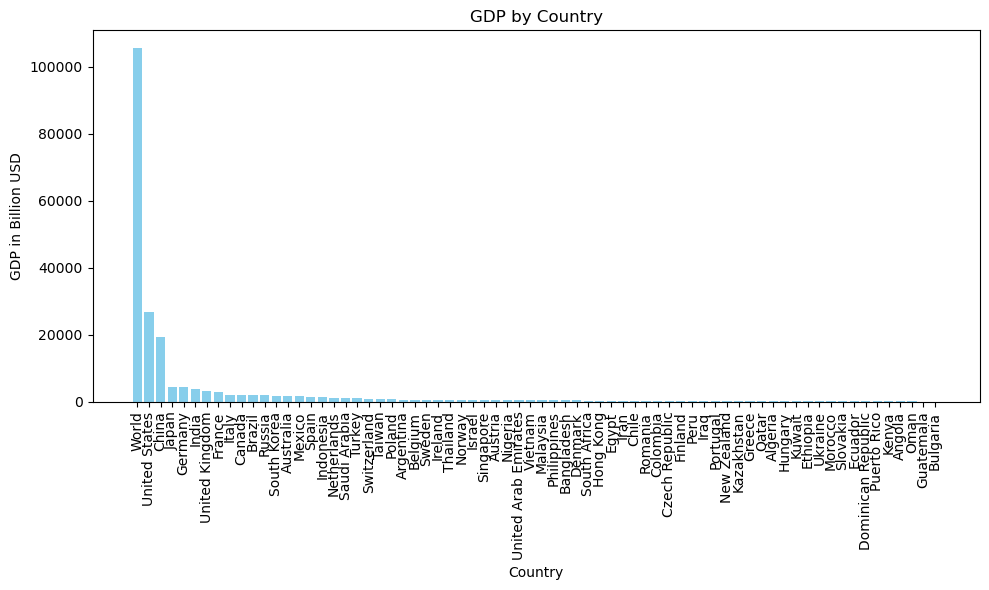

In [56]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(10, 6))

# Create a bar chart: use Country for x-axis and GDP_USD_billion for height
plt.bar(result_df['Country'], result_df['GDP_USD_billion'], color='skyblue')

# Add labels and title
plt.xlabel('Country')
plt.ylabel('GDP in Billion USD')
plt.title('GDP by Country')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()  # Adjust layout to ensure everything fits
plt.show()